In [50]:
import numpy as np
import pandas as pd
import networkx as nx
from networkx.algorithms import community
import community as community_louvain

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import os
import pathlib
import json
import datetime

from sklearn.feature_extraction.text import TfidfVectorizer
import math

In [6]:
user_articles = []
article_users = {}
with open('user_article_raw.bigraph', 'r') as f:
    lines = f.readlines()
    for line in lines:
        article, user = line.split()
        if article not in article_users:
            article_users[article] = set()
        article_users[article].add(user)

# with open('user_article_raw_gossipcop.bigraph', 'r') as f:
#     lines = f.readlines()
#     for line in lines:
#         article, user = line.split()
#         if article not in article_users:
#             article_users[article] = set()
#         article_users[article].add(user)

In [7]:
edgelist = []

article_pair_users = {}

for i, a1 in enumerate(article_users.keys()):
    for j, a2 in enumerate(article_users.keys()):
        if i < j:
            intersection = article_users[a1].intersection(article_users[a2])
            if len(intersection) > 0:
                edgelist.append((a1, a2))
                article_pair_users[(a1,a2)] = intersection

In [8]:
G = nx.Graph()
G.add_edges_from(edgelist)

In [9]:
data_dir = pathlib.Path('../small_dataset/politifact')

label_dic = {}

for label in ['real', 'fake']:
    label_dir = data_dir / label
    for a in os.listdir(label_dir):
        if label == 'real':
            label_dic[a] = 0
        else:
            label_dic[a] = 1

In [10]:
label_dic_filtered = {a: label for a, label in label_dic.items() if a in G.nodes()}

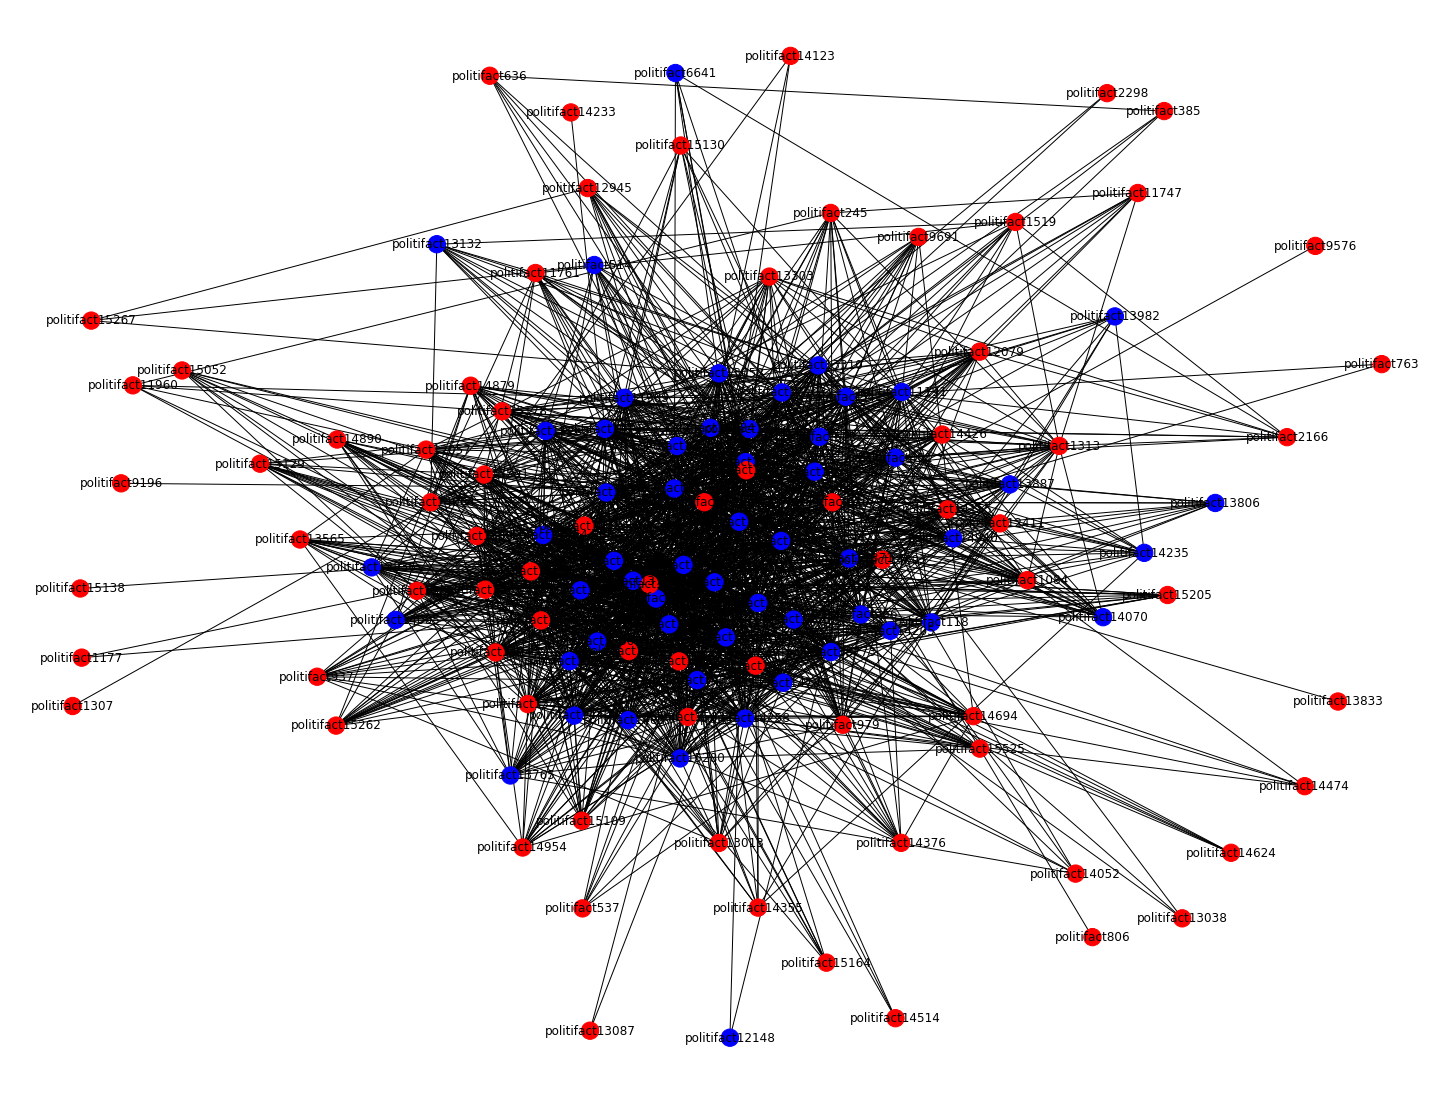

In [11]:
fig = plt.figure(figsize=(20,15))
cmap = cm.get_cmap('bwr', max(label_dic_filtered.values()) + 1)
nx.draw(G=G, pos=nx.spring_layout(G, k=1),
                       cmap=cmap, node_color=list(label_dic_filtered.values()), with_labels=True)
# fig.savefig('article_graph');
# blue = real, red = fake

In [72]:
def date_to_int(dt_time):
    return 10000*dt_time.year + 100*dt_time.month + dt_time.day


def get_times_user_followers(a1, a2, shared_users):
#     ret = {a1: {'times':[]}, a2: {'times':[]}}
    times = []
    if label_dic_filtered[a1] == 0:
        data_dir = pathlib.Path('../small_dataset/politifact/real/')
    else:
        data_dir = pathlib.Path('../small_dataset/politifact/fake/')
    article_dir = data_dir / a
    tweet_dir = article_dir / 'tweets'
    if tweet_dir.exists():
        for tweet_json in os.listdir(tweet_dir):
            with open(tweet_dir / tweet_json) as tweet:
                data = json.load(tweet)
                timestamp = pd.to_datetime(data['created_at'])
                times.append(timestamp)
    # computing BAS to include in edge weight
    if len(times) < 2:
        time_diff = 1e-10
    else:
        time_diff = (max(times) - min(times)).seconds
    
#     for a in [a1, a2]:
#         min_time, max_time = None, None
# #         if a in ret.keys():
# #             continue
# #         ret[a] = {}
#         times = []
#         if label_dic_filtered[a1] == 0:
#             data_dir = pathlib.Path('../small_dataset/politifact/real/')
#         else:
#             data_dir = pathlib.Path('../small_dataset/politifact/fake/')
#         article_dir = data_dir / a
#         tweet_dir = article_dir / 'tweets'
#         if tweet_dir.exists():
#             for tweet_json in os.listdir(tweet_dir):
#                 with open(tweet_dir / tweet_json) as tweet:
#                     data = json.load(tweet)
#                     timestamp = pd.to_datetime(data['created_at'])
#                     times.append(timestamp)
                    
# #                     if min_time is None:
# #                         min_time = timestamp
# #                     else:
# #                         min_time = min(min_time, timestamp)
                    
# #                     if max_time is None:
# #                         max_time = timestamp
# #                     else:
# #                         max_time = max(max_time, timestamp)
                    
                    
# #                     times.append(timestamp)
# #                     times.append(date_to_int(timestamp))
#         if len(a1_dta['times']) < 0:
#             if len(a2_dta['times']) < 0:
                
                
# #         if min_time is None:
# #             min_time = pd.to_datetime(datetime.datetime(1, 1, 1, 0, 0))
# #         if max_time is None:
# #             max_time = pd.to_datetime(datetime.datetime(1, 1, 1, 0, 0))
# #         ret[a]['times'] = (min_time, max_time) #np.array(times) #/ 10000
# #         ret[a]["times"] = times
        
    users_dir = pathlib.Path('../small_dataset/user_profiles/')
    followers = 0
    
    for user in shared_users:
        user_json = user + '.json'
        user_file = users_dir / user_json
        if user_file.exists():
            with open(user_file) as u:
                user_data = json.load(u)
                followers += user_data["followers_count"]
#                 print(user_data['verified'])
    return time_diff, followers

def uneven_kl_divergence(pk, qk):
    if len(pk)>len(qk):
        pk = np.random.choice(pk,len(qk))
    elif len(qk)>len(pk):
        qk = np.random.choice(qk,len(pk))
    return np.abs(np.sum(pk * np.log(pk/qk)))

def calc_edge_weight(a1_dta, a2_dta):
    times1, times2 = a1_dta['times'], a2_dta['times']
    min_time1, max_time1 = times1
    min_time2, max_time2 = times2
    
    min_time = min(min(times1), min(times2))
    max_time = max(max(times1), max(times2))
    print((min_time- max_time).mins)
    
    return (max_time - min_time).seconds
    

In [73]:
import tqdm

G2 = nx.Graph()


total_users = len(os.listdir('../small_dataset/user_profiles/'))

for (a1, a2), users in tqdm.tqdm(article_pair_users.items()):
    time_diff, followers = get_times_user_followers(a1, a2, users)
#     a1_dta, a2_dta = ret[a1], ret[a2]
    nusers = len(users)
#     print(a1_dta, a2_dta)
    print((label_dic_filtered[a1], label_dic_filtered[a2]), time_diff, followers)
    if followers > 0:
        weight = time_diff * (followers / total_users) / nusers
#         if nusers > 0:
#             weight = calc_edge_weight(a1_dta, a2_dta) / (followers / nusers)
#         else:
#             weight = calc_edge_weight(a1_dta, a2_dta) / followers
    else:
        weight = calc_edge_weight(a1_dta, a2_dta) * (followers / total_users) / nusers
#         weight = calc_edge_weight(a1_dta, a2_dta)
        
#     print((label_dic_filtered[a1], label_dic_filtered[a2]), weight, followers, nusers)
#     break
    G2.add_edge(a1, a2, weight = weight)
#     break












  0%|          | 0/2017 [00:00<?, ?it/s]










  1%|▏         | 28/2017 [00:00<00:07, 276.95it/s]










  3%|▎         | 70/2017 [00:00<00:06, 307.60it/s]

(1, 1) 1e-10 295287
(1, 1) 1e-10 2081
(1, 1) 1e-10 658
(1, 1) 1e-10 41115
(1, 1) 1e-10 135
(1, 1) 1e-10 1470
(1, 1) 1e-10 118966
(1, 1) 1e-10 293673
(1, 1) 1e-10 7640
(1, 1) 1e-10 294268
(1, 1) 1e-10 46075
(1, 1) 1e-10 16428
(1, 1) 1e-10 36108
(1, 1) 1e-10 315388
(1, 1) 1e-10 0
(1, 1) 1e-10 9337
(1, 1) 1e-10 294145
(1, 1) 1e-10 14454
(1, 1) 1e-10 69903
(1, 1) 1e-10 27710
(1, 1) 1e-10 32788
(1, 1) 1e-10 28737
(1, 1) 1e-10 21533
(1, 1) 1e-10 500
(1, 1) 1e-10 3343
(1, 1) 1e-10 135
(1, 1) 1e-10 14688
(1, 1) 1e-10 3186
(1, 1) 1e-10 6130
(1, 1) 1e-10 3688
(1, 1) 1e-10 2435
(1, 1) 1e-10 293673
(1, 1) 1e-10 293819
(1, 1) 1e-10 135
(1, 0) 1e-10 44191
(1, 0) 1e-10 47735
(1, 0) 1e-10 3636
(1, 0) 1e-10 6883
(1, 0) 1e-10 200
(1, 0) 1e-10 50043
(1, 0) 1e-10 292
(1, 0) 1e-10 1913
(1, 0) 1e-10 1470
(1, 0) 1e-10 8652
(1, 0) 1e-10 21524
(1, 0) 1e-10 229015
(1, 0) 1e-10 3412
(1, 0) 1e-10 27417
(1, 0) 1e-10 21383
(1, 0) 1e-10 27993
(1, 0) 1e-10 19208
(1, 0) 1e-10 23441
(1, 0) 1e-10 14897
(1, 0) 1e-10 249













  5%|▌         | 110/2017 [00:00<00:05, 329.42it/s]










  8%|▊         | 164/2017 [00:00<00:04, 372.69it/s]

(1, 1) 1e-10 46836
(1, 1) 1e-10 71525
(1, 1) 1e-10 9569
(1, 1) 1e-10 135779
(1, 1) 1e-10 35007
(1, 1) 1e-10 5239
(1, 1) 1e-10 39556
(1, 1) 1e-10 5423
(1, 1) 1e-10 8675
(1, 1) 1e-10 20
(1, 1) 1e-10 6248
(1, 1) 1e-10 17511
(1, 1) 1e-10 9206
(1, 1) 1e-10 24
(1, 1) 1e-10 165
(1, 1) 1e-10 581
(1, 1) 1e-10 354
(1, 1) 1e-10 29
(1, 1) 1e-10 843
(1, 1) 1e-10 29415
(1, 1) 1e-10 71058
(1, 1) 1e-10 2048
(1, 1) 1e-10 5974
(1, 1) 1e-10 9865
(1, 1) 1e-10 22074
(1, 1) 1e-10 8393
(1, 1) 1e-10 406
(1, 1) 1e-10 1887
(1, 0) 1e-10 26595
(1, 0) 1e-10 5103
(1, 0) 1e-10 8037
(1, 0) 1e-10 57106
(1, 0) 1e-10 205656
(1, 0) 1e-10 7625
(1, 0) 1e-10 52949
(1, 0) 1e-10 30232
(1, 0) 1e-10 43058
(1, 0) 1e-10 85167
(1, 0) 1e-10 61313
(1, 0) 1e-10 74
(1, 0) 1e-10 16020
(1, 0) 1e-10 3230
(1, 0) 1e-10 6166
(1, 0) 1e-10 66520
(1, 1) 1e-10 16448
(1, 1) 1e-10 42711
(1, 1) 1e-10 430
(1, 1) 1e-10 347
(1, 1) 1e-10 183
(1, 1) 1e-10 260
(1, 1) 1e-10 206
(1, 0) 1e-10 4548106
(1, 0) 1e-10 37438
(1, 0) 1e-10 16652
(1, 0) 1e-10 901
(












 10%|█         | 206/2017 [00:00<00:04, 385.71it/s]










 12%|█▏        | 251/2017 [00:00<00:04, 402.96it/s]

(1, 1) 1e-10 1635
(1, 1) 1e-10 21231
(1, 1) 1e-10 7070
(1, 1) 1e-10 12909
(1, 1) 1e-10 3605
(1, 1) 1e-10 1675
(1, 1) 1e-10 1301
(1, 1) 1e-10 770
(1, 1) 1e-10 4090
(1, 1) 1e-10 3011
(1, 1) 1e-10 11491
(1, 1) 1e-10 3018
(1, 1) 1e-10 770
(1, 1) 1e-10 4600
(1, 1) 1e-10 3011
(1, 1) 1e-10 3011
(1, 1) 1e-10 1301
(1, 1) 1e-10 11490
(1, 1) 1e-10 189
(1, 0) 1e-10 3781
(1, 0) 1e-10 509
(1, 0) 1e-10 859
(1, 0) 1e-10 3011
(1, 0) 1e-10 1879
(1, 0) 1e-10 2177
(1, 0) 1e-10 509
(1, 0) 1e-10 510
(1, 1) 1e-10 1920
(1, 1) 1e-10 18935
(1, 1) 1e-10 431
(1, 1) 1e-10 39
(1, 1) 1e-10 46695
(1, 1) 1e-10 2945
(1, 1) 1e-10 111137
(1, 1) 1e-10 121
(1, 1) 1e-10 9087
(1, 1) 1e-10 9476
(1, 1) 1e-10 8497
(1, 1) 1e-10 56
(1, 1) 1e-10 2815
(1, 1) 1e-10 10059
(1, 1) 1e-10 778
(1, 1) 1e-10 3004
(1, 1) 1e-10 10438
(1, 1) 1e-10 747
(1, 1) 1e-10 10505
(1, 1) 1e-10 28141
(1, 1) 1e-10 946
(1, 1) 1e-10 21326
(1, 1) 1e-10 17823
(1, 1) 1e-10 1684
(1, 1) 1e-10 747
(1, 0) 1e-10 8347
(1, 0) 1e-10 8347
(1, 0) 1e-10 8394
(1, 0) 1e-10 












 14%|█▍        | 290/2017 [00:00<00:04, 396.49it/s]










 17%|█▋        | 341/2017 [00:00<00:03, 424.38it/s]

(1, 1) 1e-10 116
(1, 1) 1e-10 8331
(1, 1) 1e-10 4705
(1, 1) 1e-10 802
(1, 1) 1e-10 3186
(1, 1) 1e-10 1423
(1, 1) 1e-10 1247
(1, 1) 1e-10 8031
(1, 1) 1e-10 2590
(1, 1) 1e-10 1457
(1, 0) 1e-10 2268
(1, 0) 1e-10 4547
(1, 0) 1e-10 6163
(1, 0) 1e-10 1423
(1, 0) 1e-10 3170
(1, 0) 1e-10 8
(1, 0) 1e-10 7347
(1, 0) 1e-10 2590
(1, 0) 1e-10 16188
(1, 1) 1e-10 1376
(1, 1) 1e-10 24
(1, 1) 1e-10 879
(1, 1) 1e-10 7318
(1, 1) 1e-10 13215
(1, 1) 1e-10 13786
(1, 1) 1e-10 75978
(1, 1) 1e-10 124233
(1, 1) 1e-10 133363
(1, 1) 1e-10 138965
(1, 1) 1e-10 35333
(1, 1) 1e-10 8067
(1, 1) 1e-10 245
(1, 1) 1e-10 43109
(1, 1) 1e-10 31066
(1, 1) 1e-10 168230
(1, 1) 1e-10 47
(1, 1) 1e-10 3906
(1, 1) 1e-10 132044
(1, 1) 1e-10 125458
(1, 1) 1e-10 6924
(1, 1) 1e-10 124233
(1, 1) 1e-10 124233
(1, 1) 1e-10 104
(1, 1) 1e-10 132296
(1, 1) 1e-10 5891
(1, 1) 1e-10 124233
(1, 1) 1e-10 4930
(1, 1) 1e-10 12073
(1, 1) 1e-10 1274
(1, 1) 1e-10 116
(1, 1) 1e-10 3741
(1, 1) 1e-10 381
(1, 1) 1e-10 131586
(1, 1) 1e-10 116
(1, 1) 1e-10 












 19%|█▉        | 386/2017 [00:00<00:03, 430.88it/s]










 22%|██▏       | 444/2017 [00:01<00:03, 465.73it/s]

(1, 1) 1e-10 1376
(1, 0) 1e-10 19
(1, 1) 1e-10 630
(1, 1) 1e-10 211
(1, 1) 1e-10 630
(1, 1) 1e-10 142
(1, 1) 1e-10 4160
(1, 1) 1e-10 630
(1, 1) 1e-10 4280
(1, 1) 1e-10 4160
(1, 1) 1e-10 24
(1, 1) 1e-10 24
(1, 1) 1e-10 630
(1, 1) 1e-10 654
(1, 1) 1e-10 4184
(1, 0) 1e-10 22
(1, 1) 1e-10 9
(1, 1) 1e-10 9
(1, 1) 1e-10 21842
(1, 1) 1e-10 9
(1, 1) 1e-10 18641
(1, 1) 1e-10 35275
(1, 1) 1e-10 23531
(1, 1) 1e-10 26764
(1, 1) 1e-10 944
(1, 1) 1e-10 11133
(1, 1) 1e-10 946
(1, 1) 1e-10 27527
(1, 1) 1e-10 2523
(1, 1) 1e-10 9
(1, 0) 1e-10 12
(1, 0) 1e-10 21091
(1, 0) 1e-10 1322
(1, 0) 1e-10 20146
(1, 0) 1e-10 2854
(1, 0) 1e-10 118
(1, 0) 1e-10 407
(1, 0) 1e-10 810
(1, 0) 1e-10 541
(1, 1) 1e-10 829
(1, 1) 1e-10 9
(1, 1) 1e-10 1439
(1, 1) 1e-10 6812
(1, 1) 1e-10 348
(1, 1) 1e-10 406
(1, 1) 1e-10 551
(1, 1) 1e-10 4585
(1, 1) 1e-10 25573
(1, 1) 1e-10 1096
(1, 1) 1e-10 1744
(1, 1) 1e-10 308
(1, 1) 1e-10 286
(1, 1) 1e-10 111
(1, 1) 1e-10 3005
(1, 1) 1e-10 2365
(1, 1) 1e-10 659
(1, 1) 1e-10 35
(1, 1) 1e-10












 24%|██▍       | 492/2017 [00:01<00:03, 443.45it/s]

(1, 1) 1e-10 6232
(1, 1) 1e-10 8263
(1, 1) 1e-10 4997
(1, 1) 1e-10 14647
(1, 1) 1e-10 5510
(1, 1) 1e-10 37283
(1, 1) 1e-10 53471
(1, 1) 1e-10 43462
(1, 1) 1e-10 38846
(1, 1) 1e-10 20928
(1, 1) 1e-10 1090
(1, 1) 1e-10 858
(1, 1) 1e-10 644
(1, 1) 1e-10 580
(1, 1) 1e-10 3204
(1, 1) 1e-10 9176
(1, 1) 1e-10 3011
(1, 1) 1e-10 165
(1, 1) 1e-10 8660
(1, 1) 1e-10 35725
(1, 1) 1e-10 3763
(1, 1) 1e-10 9638
(1, 1) 1e-10 1351
(1, 1) 1e-10 9223
(1, 1) 1e-10 1551
(1, 1) 1e-10 9258
(1, 1) 1e-10 14629
(1, 1) 1e-10 4057
(1, 1) 1e-10 1814
(1, 1) 1e-10 587
(1, 1) 1e-10 2236
(1, 0) 1e-10 4571
(1, 0) 1e-10 875
(1, 0) 1e-10 38
(1, 0) 1e-10 4262
(1, 0) 1e-10 27943
(1, 0) 1e-10 3011
(1, 0) 1e-10 4662
(1, 0) 1e-10 1905
(1, 0) 1e-10 2502
(1, 0) 1e-10 5569
(1, 0) 1e-10 409
(1, 1) 1e-10 14241
(1, 1) 1e-10 13215
(1, 1) 1e-10 14515
(1, 1) 1e-10 64572
(1, 1) 1e-10 70494
(1, 1) 1e-10 1470
(1, 1) 1e-10 40288
(1, 1) 1e-10 40288
(1, 1) 1e-10 1470
(1, 1) 1e-10 2530
(1, 1) 1e-10 2434
(1, 1) 1e-10 2602
(1, 1) 1e-10 4547
(1,












 27%|██▋       | 538/2017 [00:01<00:03, 439.41it/s]

(1, 1) 1e-10 7439
(1, 1) 1e-10 119121
(1, 1) 1e-10 11091
(1, 1) 1e-10 21091
(1, 1) 1e-10 3011
(1, 1) 1e-10 1788
(1, 1) 1e-10 3773
(1, 1) 1e-10 1075965
(1, 1) 1e-10 10282
(1, 1) 1e-10 22910
(1, 1) 1e-10 1182809
(1, 1) 1e-10 6738
(1, 1) 1e-10 4710
(1, 1) 1e-10 17190
(1, 1) 1e-10 18464
(1, 1) 1e-10 17747
(1, 1) 1e-10 39485
(1, 0) 1e-10 243037
(1, 0) 1e-10 76143839
(1, 0) 1e-10 10007
(1, 0) 1e-10 201441
(1, 0) 1e-10 92269
(1, 0) 1e-10 1055266
(1, 0) 1e-10 1272426
(1, 0) 1e-10 384127
(1, 0) 1e-10 307292
(1, 0) 1e-10 4160
(1, 0) 1e-10 163724













 29%|██▉       | 583/2017 [00:01<00:05, 242.28it/s]

(1, 0) 1e-10 76981627
(1, 0) 1e-10 51
(1, 0) 1e-10 3419461
(1, 0) 1e-10 2085925
(1, 0) 1e-10 80334
(1, 0) 1e-10 4648
(1, 0) 1e-10 2394429
(1, 0) 1e-10 750
(1, 0) 1e-10 57620067
(1, 0) 1e-10 2674
(1, 0) 1e-10 808733
(1, 0) 1e-10 99898
(1, 0) 1e-10 26857
(1, 0) 1e-10 296741
(1, 0) 1e-10 8757
(1, 0) 1e-10 1556525
(1, 0) 1e-10 803197
(1, 0) 1e-10 61453
(1, 0) 1e-10 8417
(1, 0) 1e-10 1686475
(1, 0) 1e-10 164538
(1, 0) 1e-10 23894
(1, 0) 1e-10 48062143
(1, 0) 1e-10 14453298
(1, 0) 1e-10 1537536
(1, 0) 1e-10 1245194
(1, 0) 1e-10 50274
(1, 0) 1e-10 3391205













 31%|███       | 618/2017 [00:01<00:05, 259.44it/s]










 33%|███▎      | 661/2017 [00:01<00:04, 294.44it/s]

(1, 0) 1e-10 71387120
(1, 1) 1e-10 59027
(1, 1) 1e-10 497
(1, 1) 1e-10 587
(1, 1) 1e-10 2709
(1, 1) 1e-10 15208
(1, 1) 1e-10 32828
(1, 1) 1e-10 19019
(1, 1) 1e-10 44274
(1, 1) 1e-10 892
(1, 1) 1e-10 536
(1, 1) 1e-10 7807
(1, 1) 1e-10 4155
(1, 1) 1e-10 7478
(1, 1) 1e-10 289
(1, 1) 1e-10 13998
(1, 1) 1e-10 165
(1, 1) 1e-10 3902
(1, 1) 1e-10 7512
(1, 1) 1e-10 1645
(1, 1) 1e-10 1330
(1, 1) 1e-10 282
(1, 1) 1e-10 40921
(1, 1) 1e-10 433
(1, 1) 1e-10 4173
(1, 1) 1e-10 1160
(1, 1) 1e-10 58839
(1, 1) 1e-10 1510
(1, 1) 1e-10 24463
(1, 1) 1e-10 587
(1, 1) 1e-10 1147
(1, 0) 1e-10 32971
(1, 0) 1e-10 16163
(1, 0) 1e-10 1677
(1, 0) 1e-10 16772
(1, 0) 1e-10 4890
(1, 0) 1e-10 872
(1, 0) 1e-10 13215
(1, 0) 1e-10 14251
(1, 0) 1e-10 2620
(1, 1) 1e-10 425214
(1, 1) 1e-10 70
(1, 1) 1e-10 429184
(1, 1) 1e-10 696603
(1, 1) 1e-10 696603
(1, 1) 1e-10 124233
(1, 1) 1e-10 427838
(1, 1) 1e-10 414
(1, 1) 1e-10 130195
(1, 1) 1e-10 124233
(1, 1) 1e-10 115647
(1, 1) 1e-10 696603
(1, 1) 1e-10 124233
(1, 1) 1e-10 619
(1












 35%|███▍      | 698/2017 [00:01<00:04, 268.21it/s]

(1, 0) 1e-10 2929
(1, 1) 1e-10 291
(1, 1) 1e-10 72589
(1, 1) 1e-10 9197
(1, 1) 1e-10 11725
(1, 1) 1e-10 285924
(1, 1) 1e-10 135077
(1, 1) 1e-10 45079
(1, 1) 1e-10 3831
(1, 1) 1e-10 272
(1, 1) 1e-10 23514
(1, 1) 1e-10 3374
(1, 1) 1e-10 11325
(1, 1) 1e-10 5036
(1, 1) 1e-10 438
(1, 1) 1e-10 770
(1, 1) 1e-10 4204
(1, 1) 1e-10 33906
(1, 1) 1e-10 961
(1, 1) 1e-10 55907
(1, 1) 1e-10 36479
(1, 1) 1e-10 12326
(1, 1) 1e-10 17546
(1, 1) 1e-10 994
(1, 1) 1e-10 878
(1, 1) 1e-10 373
(1, 1) 1e-10 8302
(1, 1) 1e-10 120201
(1, 1) 1e-10 24235
(1, 1) 1e-10 6076
(1, 1) 1e-10 12383
(1, 1) 1e-10 42940
(1, 1) 1e-10 126
(1, 1) 1e-10 57734
(1, 1) 1e-10 5189
(1, 1) 1e-10 72768
(1, 1) 1e-10 3060
(1, 1) 1e-10 108
(1, 0) 1e-10 104004
(1, 0) 1e-10 7202
(1, 0) 1e-10 1117
(1, 0) 1e-10 148













 36%|███▌      | 731/2017 [00:02<00:04, 273.31it/s]










 39%|███▉      | 787/2017 [00:02<00:03, 322.68it/s]

(1, 0) 1e-10 26079
(1, 0) 1e-10 178
(1, 0) 1e-10 4846
(1, 0) 1e-10 17668
(1, 0) 1e-10 6771
(1, 0) 1e-10 30944
(1, 0) 1e-10 11831
(1, 0) 1e-10 137686
(1, 0) 1e-10 28228
(1, 0) 1e-10 15553
(1, 0) 1e-10 1551
(1, 0) 1e-10 70672
(1, 1) 1e-10 1673
(1, 1) 1e-10 743
(1, 1) 1e-10 6299
(1, 1) 1e-10 104459
(1, 1) 1e-10 425404
(1, 1) 1e-10 8940
(1, 1) 1e-10 291
(1, 1) 1e-10 134723
(1, 1) 1e-10 423868
(1, 1) 1e-10 8882
(1, 1) 1e-10 130250
(1, 1) 1e-10 578
(1, 1) 1e-10 124233
(1, 1) 1e-10 127307
(1, 1) 1e-10 34
(1, 1) 1e-10 124398
(1, 1) 1e-10 55
(1, 1) 1e-10 412
(1, 1) 1e-10 1032
(1, 1) 1e-10 73
(1, 1) 1e-10 134590
(1, 1) 1e-10 1977
(1, 1) 1e-10 17874
(1, 1) 1e-10 9241
(1, 1) 1e-10 10021
(1, 1) 1e-10 6988
(1, 1) 1e-10 2521
(1, 1) 1e-10 9740
(1, 1) 1e-10 295839
(1, 1) 1e-10 419737
(1, 1) 1e-10 2498
(1, 0) 1e-10 8347
(1, 0) 1e-10 8347
(1, 0) 1e-10 414
(1, 0) 1e-10 414
(1, 0) 1e-10 566
(1, 0) 1e-10 3235
(1, 0) 1e-10 132768
(1, 0) 1e-10 124955
(1, 0) 1e-10 1915
(1, 0) 1e-10 124233
(1, 0) 1e-10 8347
(1,












 42%|████▏     | 842/2017 [00:02<00:03, 368.05it/s]

(1, 1) 1e-10 38
(1, 1) 1e-10 53
(1, 1) 1e-10 25
(1, 1) 1e-10 53
(1, 1) 1e-10 53
(1, 1) 1e-10 53
(1, 1) 1e-10 111
(1, 1) 1e-10 2200
(1, 1) 1e-10 53
(1, 0) 1e-10 54326
(1, 0) 1e-10 4978
(1, 0) 1e-10 2999
(1, 1) 1e-10 51041
(1, 1) 1e-10 11904
(1, 1) 1e-10 35969
(1, 1) 1e-10 165
(1, 1) 1e-10 1341
(1, 1) 1e-10 8056
(1, 1) 1e-10 732
(1, 1) 1e-10 578
(1, 1) 1e-10 438
(1, 1) 1e-10 49
(1, 1) 1e-10 1843
(1, 1) 1e-10 1126
(1, 1) 1e-10 933
(1, 1) 1e-10 35725
(1, 1) 1e-10 1190
(1, 1) 1e-10 853
(1, 1) 1e-10 3352
(1, 1) 1e-10 1381
(1, 1) 1e-10 1214
(1, 1) 1e-10 783
(1, 1) 1e-10 5389
(1, 1) 1e-10 587
(1, 1) 1e-10 406
(1, 0) 1e-10 8297
(1, 0) 1e-10 9154
(1, 0) 1e-10 413
(1, 0) 1e-10 7544
(1, 0) 1e-10 470
(1, 0) 1e-10 406
(1, 1) 1e-10 479
(1, 1) 1e-10 479
(1, 0) 1e-10 3636
(1, 0) 1e-10 3636
(1, 0) 1e-10 94
(1, 0) 1e-10 33888
(1, 0) 1e-10 3636
(1, 1) 1e-10 204150
(1, 1) 1e-10 39257
(1, 1) 1e-10 5634
(1, 1) 1e-10 3685
(1, 1) 1e-10 22938
(1, 1) 1e-10 10230
(1, 1) 1e-10 329
(1, 1) 1e-10 3720
(1, 1) 1e-10 57












 44%|████▍     | 886/2017 [00:02<00:03, 324.93it/s]










 46%|████▌     | 925/2017 [00:02<00:03, 312.65it/s]

(1, 1) 1e-10 27312
(1, 1) 1e-10 3076
(1, 1) 1e-10 4872
(1, 1) 1e-10 28136
(1, 1) 1e-10 126
(1, 1) 1e-10 11159
(1, 1) 1e-10 13118
(1, 1) 1e-10 192
(1, 1) 1e-10 41687
(1, 1) 1e-10 2667
(1, 1) 1e-10 104727
(1, 0) 1e-10 6150
(1, 0) 1e-10 2822
(1, 0) 1e-10 37639
(1, 0) 1e-10 2433
(1, 0) 1e-10 9955
(1, 0) 1e-10 76164
(1, 0) 1e-10 18020
(1, 0) 1e-10 1715
(1, 0) 1e-10 68312
(1, 0) 1e-10 4742
(1, 0) 1e-10 34025
(1, 0) 1e-10 18785
(1, 0) 1e-10 137686
(1, 0) 1e-10 34769
(1, 0) 1e-10 31470
(1, 0) 1e-10 1208
(1, 0) 1e-10 10189
(1, 0) 1e-10 2209
(1, 1) 1e-10 12296
(1, 1) 1e-10 30572
(1, 1) 1e-10 2915
(1, 1) 1e-10 2800
(1, 1) 1e-10 26503
(1, 1) 1e-10 501
(1, 1) 1e-10 59051
(1, 1) 1e-10 54544
(1, 1) 1e-10 630
(1, 1) 1e-10 14004
(1, 1) 1e-10 1785
(1, 1) 1e-10 60844
(1, 1) 1e-10 1126
(1, 1) 1e-10 39973
(1, 1) 1e-10 116
(1, 1) 1e-10 320
(1, 1) 1e-10 136790
(1, 1) 1e-10 31930
(1, 1) 1e-10 1346
(1, 1) 1e-10 349
(1, 1) 1e-10 2713
(1, 1) 1e-10 116
(1, 1) 1e-10 44804













 48%|████▊     | 961/2017 [00:02<00:03, 280.87it/s]

(1, 1) 1e-10 101045
(1, 1) 1e-10 44017
(1, 1) 1e-10 3815
(1, 1) 1e-10 25842
(1, 1) 1e-10 6988
(1, 1) 1e-10 18092
(1, 1) 1e-10 100816
(1, 1) 1e-10 3864
(1, 1) 1e-10 15288
(1, 1) 1e-10 9
(1, 1) 1e-10 13911
(1, 0) 1e-10 41369
(1, 0) 1e-10 8347
(1, 0) 1e-10 3805
(1, 0) 1e-10 28630
(1, 0) 1e-10 1117
(1, 0) 1e-10 5324
(1, 0) 1e-10 47676
(1, 0) 1e-10 27943
(1, 0) 1e-10 4018
(1, 0) 1e-10 1470
(1, 0) 1e-10 3011
(1, 0) 1e-10 126
(1, 0) 1e-10 7107
(1, 0) 1e-10 58609
(1, 0) 1e-10 16499
(1, 0) 1e-10 8347
(1, 0) 1e-10 1484
(1, 0) 1e-10 3109
(1, 0) 1e-10 31157
(1, 0) 1e-10 4236
(1, 0) 1e-10 878
(1, 0) 1e-10 46
(1, 0) 1e-10 31920
(1, 0) 1e-10 37882
(1, 1) 1e-10 156037
(1, 1) 1e-10 124233
(1, 1) 1e-10 459043
(1, 1) 1e-10 4827
(1, 1) 1e-10 130303
(1, 1) 1e-10 124233
(1, 1) 1e-10 277
(1, 1) 1e-10 125901
(1, 1) 1e-10 52
(1, 1) 1e-10 1470
(1, 1) 1e-10 124233
(1, 1) 1e-10 660
(1, 1) 1e-10 35725
(1, 1) 1e-10 200
(1, 1) 1e-10 1470
(1, 1) 1e-10 2101
(1, 1) 1e-10 125308
(1, 1) 1e-10 48560
(1, 1) 1e-10 1079
(1, 












 50%|█████     | 1010/2017 [00:02<00:03, 321.68it/s]










 53%|█████▎    | 1070/2017 [00:02<00:02, 372.83it/s]

(1, 1) 1e-10 9915
(1, 1) 1e-10 697729
(1, 1) 1e-10 165
(1, 1) 1e-10 696603
(1, 1) 1e-10 756
(1, 1) 1e-10 5
(1, 1) 1e-10 8680
(1, 1) 1e-10 1229
(1, 1) 1e-10 696603
(1, 1) 1e-10 898
(1, 1) 1e-10 215
(1, 1) 1e-10 9345
(1, 1) 1e-10 803
(1, 1) 1e-10 921
(1, 0) 1e-10 38696
(1, 0) 1e-10 8347
(1, 0) 1e-10 696603
(1, 0) 1e-10 705115
(1, 0) 1e-10 696603
(1, 0) 1e-10 1318
(1, 0) 1e-10 8347
(1, 0) 1e-10 8347
(1, 0) 1e-10 582
(1, 0) 1e-10 39953
(1, 1) 1e-10 286
(1, 1) 1e-10 733
(1, 1) 1e-10 337
(1, 1) 1e-10 9890
(1, 1) 1e-10 315
(1, 1) 1e-10 3072
(1, 1) 1e-10 22
(1, 1) 1e-10 22
(1, 1) 1e-10 863
(1, 1) 1e-10 2864
(1, 1) 1e-10 891
(1, 1) 1e-10 2404
(1, 0) 1e-10 256
(1, 1) 1e-10 20
(1, 1) 1e-10 302
(1, 1) 1e-10 696623
(1, 1) 1e-10 16639
(1, 1) 1e-10 90215
(1, 1) 1e-10 710938
(1, 1) 1e-10 1015
(1, 1) 1e-10 90215
(1, 1) 1e-10 349
(1, 1) 1e-10 20697
(1, 1) 1e-10 530
(1, 1) 1e-10 696603
(1, 1) 1e-10 2579
(1, 1) 1e-10 4622
(1, 1) 1e-10 196
(1, 1) 1e-10 545
(1, 0) 1e-10 2005
(1, 0) 1e-10 696603
(1, 0) 1e-10












 56%|█████▌    | 1130/2017 [00:03<00:02, 420.46it/s]










 59%|█████▉    | 1192/2017 [00:03<00:01, 462.62it/s]

(1, 0) 1e-10 3970
(1, 0) 1e-10 30988
(1, 1) 1e-10 522
(1, 1) 1e-10 44034
(1, 1) 1e-10 1974
(1, 1) 1e-10 1029
(1, 1) 1e-10 1619
(1, 1) 1e-10 3826
(1, 1) 1e-10 5505
(1, 1) 1e-10 3184
(1, 1) 1e-10 584
(1, 1) 1e-10 774
(1, 1) 1e-10 19451
(1, 1) 1e-10 678
(1, 1) 1e-10 2590
(1, 1) 1e-10 12220
(1, 1) 1e-10 1095
(1, 1) 1e-10 17287
(1, 1) 1e-10 1001
(1, 1) 1e-10 1185
(1, 1) 1e-10 10000
(1, 1) 1e-10 9539
(1, 1) 1e-10 1125
(1, 1) 1e-10 2590
(1, 1) 1e-10 921
(1, 0) 1e-10 15566
(1, 0) 1e-10 8347
(1, 0) 1e-10 414
(1, 0) 1e-10 1138
(1, 0) 1e-10 23525
(1, 0) 1e-10 1095
(1, 0) 1e-10 587
(1, 0) 1e-10 8347
(1, 0) 1e-10 8347
(1, 0) 1e-10 826
(1, 0) 1e-10 2590
(1, 0) 1e-10 3693
(1, 1) 1e-10 124233
(1, 1) 1e-10 124233
(1, 1) 1e-10 124233
(1, 1) 1e-10 108
(1, 1) 1e-10 124233
(1, 1) 1e-10 129837
(1, 0) 1e-10 414
(1, 0) 1e-10 414
(1, 0) 1e-10 124233
(1, 0) 1e-10 124233
(1, 0) 1e-10 5082
(1, 0) 1e-10 124233
(1, 0) 1e-10 5548
(1, 1) 1e-10 578
(1, 1) 1e-10 578
(1, 1) 1e-10 578
(1, 1) 1e-10 124671
(1, 1) 1e-10 124












 62%|██████▏   | 1246/2017 [00:03<00:01, 481.83it/s]










 64%|██████▍   | 1299/2017 [00:03<00:01, 494.00it/s]

(1, 0) 1e-10 1096
(1, 1) 1e-10 5867
(1, 1) 1e-10 59
(1, 1) 1e-10 7348
(1, 1) 1e-10 1457
(1, 0) 1e-10 133
(1, 0) 1e-10 2679
(1, 0) 1e-10 62
(1, 1) 1e-10 5138
(1, 0) 1e-10 750
(1, 0) 1e-10 750
(1, 1) 1e-10 38067
(1, 1) 1e-10 3011
(1, 1) 1e-10 584
(1, 1) 1e-10 22617
(1, 1) 1e-10 91299
(1, 1) 1e-10 2147
(1, 1) 1e-10 29338
(1, 1) 1e-10 8276
(1, 1) 1e-10 27369
(1, 1) 1e-10 63
(1, 1) 1e-10 8770
(1, 1) 1e-10 136
(1, 0) 1e-10 35221
(1, 0) 1e-10 37817
(1, 0) 1e-10 1787
(1, 0) 1e-10 50934
(1, 0) 1e-10 427
(1, 0) 1e-10 1470
(1, 0) 1e-10 3260
(1, 0) 1e-10 142861
(1, 0) 1e-10 3393
(1, 0) 1e-10 20
(1, 0) 1e-10 1923
(1, 0) 1e-10 47957
(1, 0) 1e-10 362
(1, 0) 1e-10 90215
(1, 0) 1e-10 249
(1, 0) 1e-10 319
(1, 0) 1e-10 10610
(1, 1) 1e-10 165
(1, 1) 1e-10 124233
(1, 1) 1e-10 961
(1, 1) 1e-10 3038
(1, 1) 1e-10 165
(1, 1) 1e-10 124233
(1, 0) 1e-10 124398
(1, 0) 1e-10 124233
(1, 0) 1e-10 124233
(1, 0) 1e-10 117
(1, 1) 1e-10 1996
(1, 1) 1e-10 54031
(1, 1) 1e-10 349
(1, 1) 1e-10 6050
(1, 1) 1e-10 306
(1, 1) 1e












 67%|██████▋   | 1354/2017 [00:03<00:01, 509.18it/s]










 70%|███████   | 1416/2017 [00:03<00:01, 536.01it/s]

(1, 0) 1e-10 27417
(1, 0) 1e-10 2590
(1, 0) 1e-10 1801
(1, 0) 1e-10 584
(1, 0) 1e-10 809
(1, 0) 1e-10 15
(1, 1) 1e-10 1720
(1, 1) 1e-10 116
(1, 1) 1e-10 210
(1, 1) 1e-10 2239
(1, 1) 1e-10 8504
(1, 1) 1e-10 699
(1, 1) 1e-10 29272
(1, 1) 1e-10 110
(1, 1) 1e-10 887
(1, 0) 1e-10 1470
(1, 0) 1e-10 1470
(1, 0) 1e-10 439
(1, 0) 1e-10 1470
(1, 1) 1e-10 2101
(1, 1) 1e-10 17157
(1, 0) 1e-10 230629
(1, 0) 1e-10 2101
(1, 0) 1e-10 216084
(1, 0) 1e-10 11090
(1, 0) 1e-10 4652
(1, 0) 1e-10 4652
(1, 1) 1e-10 224
(1, 0) 1e-10 770
(1, 0) 1e-10 770
(1, 1) 1e-10 63
(1, 1) 1e-10 4547
(1, 1) 1e-10 3178
(1, 1) 1e-10 2820
(1, 1) 1e-10 1277
(1, 1) 1e-10 1265
(1, 1) 1e-10 124233
(1, 1) 1e-10 132404
(1, 0) 1e-10 2268
(1, 0) 1e-10 28894
(1, 0) 1e-10 4547
(1, 0) 1e-10 124233
(1, 0) 1e-10 3153
(1, 0) 1e-10 124955
(1, 0) 1e-10 90215
(1, 0) 1e-10 124233
(1, 0) 1e-10 473
(1, 0) 1e-10 3
(1, 0) 1e-10 90215
(1, 1) 1e-10 349
(1, 1) 1e-10 24
(1, 1) 1e-10 349
(1, 1) 1e-10 349
(1, 1) 1e-10 26283
(1, 1) 1e-10 3337
(1, 1) 1e-10












 73%|███████▎  | 1472/2017 [00:03<00:01, 517.66it/s]










 76%|███████▌  | 1526/2017 [00:03<00:01, 479.87it/s]

(1, 1) 1e-10 21
(1, 1) 1e-10 7988
(1, 0) 1e-10 11295
(1, 0) 1e-10 27946
(1, 0) 1e-10 1175
(1, 0) 1e-10 15112
(1, 0) 1e-10 704
(1, 0) 1e-10 13016
(1, 0) 1e-10 803
(1, 0) 1e-10 4110
(1, 0) 1e-10 9956
(1, 0) 1e-10 5987
(1, 0) 1e-10 77
(1, 0) 1e-10 7986
(1, 0) 1e-10 46734
(1, 0) 1e-10 3497
(1, 0) 1e-10 7986
(1, 1) 1e-10 1236
(1, 1) 1e-10 1859
(1, 0) 1e-10 559717
(1, 0) 1e-10 1660
(1, 0) 1e-10 14722
(1, 0) 1e-10 42600
(1, 0) 1e-10 363939
(1, 0) 1e-10 20651
(1, 0) 1e-10 5902
(1, 0) 1e-10 2025724
(1, 0) 1e-10 1595766
(1, 0) 1e-10 24049
(1, 0) 1e-10 851465
(1, 0) 1e-10 696603
(1, 0) 1e-10 1909141
(1, 0) 1e-10 118799
(1, 0) 1e-10 17933
(1, 0) 1e-10 388703
(1, 0) 1e-10 19231
(1, 0) 1e-10 806264
(1, 0) 1e-10 57858
(1, 0) 1e-10 3711
(1, 0) 1e-10 65424
(1, 0) 1e-10 37356
(1, 0) 1e-10 598802
(1, 0) 1e-10 71826
(1, 0) 1e-10 46835
(1, 0) 1e-10 12319
(1, 0) 1e-10 112766
(1, 0) 1e-10 162654
(1, 1) 1e-10 2159
(1, 0) 1e-10 260
(1, 0) 1e-10 2713
(1, 1) 1e-10 6988
(1, 1) 1e-10 5852
(1, 1) 1e-10 2502
(1, 1) 












 78%|███████▊  | 1580/2017 [00:03<00:00, 495.33it/s]

(1, 0) 1e-10 27447
(1, 0) 1e-10 10939
(1, 0) 1e-10 8347
(1, 0) 1e-10 493
(1, 0) 1e-10 1255
(1, 0) 1e-10 18464
(1, 0) 1e-10 810
(1, 1) 1e-10 295255
(1, 1) 1e-10 2591
(1, 1) 1e-10 1890
(1, 0) 1e-10 18239
(1, 0) 1e-10 850
(1, 0) 1e-10 7090
(1, 0) 1e-10 1224
(1, 0) 1e-10 2693
(1, 0) 1e-10 5324
(1, 0) 1e-10 509
(1, 0) 1e-10 826
(1, 0) 1e-10 15805
(1, 0) 1e-10 5076
(1, 0) 1e-10 2352
(1, 0) 1e-10 6149
(1, 0) 1e-10 1887
(1, 0) 1e-10 414
(1, 0) 1e-10 1040
(1, 0) 1e-10 1729
(1, 0) 1e-10 133872
(1, 0) 1e-10 134692
(1, 0) 1e-10 5708
(1, 0) 1e-10 14333
(1, 0) 1e-10 124233
(1, 0) 1e-10 0
(1, 0) 1e-10 7980
(1, 0) 1e-10 3761
(1, 0) 1e-10 7752
(1, 0) 1e-10 2590
(1, 0) 1e-10 930
(1, 0) 1e-10 28894
(1, 0) 1e-10 4847
(1, 0) 1e-10 5292
(1, 0) 1e-10 2236
(1, 0) 1e-10 39
(1, 0) 1e-10 226
(1, 0) 1e-10 235
(1, 0) 1e-10 351
(1, 0) 1e-10 2498
(1, 0) 1e-10 2498
(0, 0) 1e-10 35753
(0, 0) 1e-10 10984
(0, 0) 1e-10 463662
(0, 0) 1e-10 3849
(0, 0) 1e-10 606973
(0, 0) 1e-10 11494
(0, 0) 1e-10 8347
(0, 0) 1e-10 47366
(0












 81%|████████  | 1631/2017 [00:04<00:00, 413.71it/s]










 84%|████████▎ | 1689/2017 [00:04<00:00, 451.49it/s]

(0, 0) 1e-10 24332676
(0, 0) 1e-10 32626
(0, 0) 1e-10 981
(0, 0) 1e-10 19879799
(0, 0) 1e-10 2871654
(0, 0) 1e-10 172668
(0, 0) 1e-10 18147
(0, 0) 1e-10 1184360
(0, 0) 1e-10 23863026
(0, 0) 1e-10 23452424
(0, 0) 1e-10 1540581
(0, 0) 1e-10 50274
(0, 0) 1e-10 11659585
(0, 0) 1e-10 97896417
(0, 0) 1e-10 8347
(0, 0) 1e-10 8347
(0, 0) 1e-10 8347
(0, 0) 1e-10 1660
(0, 0) 1e-10 1660
(0, 0) 1e-10 93602
(0, 0) 1e-10 11412
(0, 0) 1e-10 3762513
(0, 0) 1e-10 33048
(0, 0) 1e-10 8354
(0, 0) 1e-10 271
(0, 0) 1e-10 289135
(0, 0) 1e-10 4222
(0, 0) 1e-10 8310
(0, 0) 1e-10 921
(0, 0) 1e-10 263230
(0, 0) 1e-10 101479
(0, 0) 1e-10 228498
(0, 0) 1e-10 4690
(0, 0) 1e-10 39921
(0, 0) 1e-10 154
(0, 0) 1e-10 48522
(0, 0) 1e-10 2822
(0, 0) 1e-10 236589
(0, 0) 1e-10 26303
(0, 0) 1e-10 227144
(0, 0) 1e-10 9130
(0, 0) 1e-10 53
(0, 0) 1e-10 0
(0, 0) 1e-10 1411
(0, 0) 1e-10 87441
(0, 0) 1e-10 8768
(0, 0) 1e-10 16448
(0, 0) 1e-10 316
(0, 0) 1e-10 16448
(0, 0) 1e-10 1438
(0, 0) 1e-10 16683
(0, 0) 1e-10 26245
(0, 0) 1e-












 86%|████████▋ | 1743/2017 [00:04<00:00, 465.72it/s]










 89%|████████▉ | 1792/2017 [00:04<00:00, 465.24it/s]

(0, 0) 1e-10 2158
(0, 0) 1e-10 8506069
(0, 0) 1e-10 13019
(0, 0) 1e-10 2318
(0, 0) 1e-10 8504037
(0, 0) 1e-10 2318
(0, 0) 1e-10 12935009
(0, 0) 1e-10 54258
(0, 0) 1e-10 9389587
(0, 0) 1e-10 8518374
(0, 0) 1e-10 951
(0, 0) 1e-10 9722512
(0, 0) 1e-10 25584
(0, 0) 1e-10 34583
(0, 0) 1e-10 3024
(0, 0) 1e-10 2657
(0, 0) 1e-10 1470
(0, 0) 1e-10 24437
(0, 0) 1e-10 696747
(0, 0) 1e-10 1331338
(0, 0) 1e-10 27259
(0, 0) 1e-10 1234
(0, 0) 1e-10 1470
(0, 0) 1e-10 13858
(0, 0) 1e-10 539
(0, 0) 1e-10 2680
(0, 0) 1e-10 31950
(0, 0) 1e-10 1234
(0, 0) 1e-10 174115
(0, 0) 1e-10 36025
(0, 0) 1e-10 18013
(0, 0) 1e-10 598802
(0, 0) 1e-10 97917
(0, 0) 1e-10 8778331
(0, 0) 1e-10 68675
(0, 0) 1e-10 18235
(0, 0) 1e-10 15038
(0, 0) 1e-10 22446
(0, 0) 1e-10 15038
(0, 0) 1e-10 18914
(0, 0) 1e-10 11695
(0, 0) 1e-10 3197
(0, 0) 1e-10 7851
(0, 0) 1e-10 17002
(0, 0) 1e-10 12789
(0, 0) 1e-10 24644
(0, 0) 1e-10 12657
(0, 0) 1e-10 426072
(0, 0) 1e-10 10527
(0, 0) 1e-10 2304
(0, 0) 1e-10 13526
(0, 0) 1e-10 461
(0, 0) 1e-












 91%|█████████▏| 1841/2017 [00:04<00:00, 445.79it/s]










 94%|█████████▍| 1898/2017 [00:04<00:00, 475.68it/s]

(0, 0) 1e-10 126590609
(0, 0) 1e-10 1115
(0, 0) 1e-10 15038
(0, 0) 1e-10 15038
(0, 0) 1e-10 15038
(0, 0) 1e-10 8070
(0, 0) 1e-10 293
(0, 0) 1e-10 2702
(0, 0) 1e-10 1115
(0, 0) 1e-10 2840
(0, 0) 1e-10 25854
(0, 0) 1e-10 1836
(0, 0) 1e-10 3517708
(0, 0) 1e-10 1227
(0, 0) 1e-10 1234
(0, 0) 1e-10 3926
(0, 0) 1e-10 3286
(0, 0) 1e-10 539656
(0, 0) 1e-10 5464
(0, 0) 1e-10 9123
(0, 0) 1e-10 2318
(0, 0) 1e-10 830316
(0, 0) 1e-10 8536
(0, 0) 1e-10 2899699
(0, 0) 1e-10 506157
(0, 0) 1e-10 381063
(0, 0) 1e-10 254491
(0, 0) 1e-10 50097885
(0, 0) 1e-10 84757
(0, 0) 1e-10 84757
(0, 0) 1e-10 84757
(0, 0) 1e-10 288
(0, 0) 1e-10 1325
(0, 0) 1e-10 2120505
(0, 0) 1e-10 11451
(0, 0) 1e-10 2049
(0, 0) 1e-10 27807
(0, 0) 1e-10 6512
(0, 0) 1e-10 1482
(0, 0) 1e-10 130912
(0, 0) 1e-10 60391
(0, 0) 1e-10 7028
(0, 0) 1e-10 136117
(0, 0) 1e-10 8208
(0, 0) 1e-10 1356
(0, 0) 1e-10 2004050
(0, 0) 1e-10 48508
(0, 0) 1e-10 128868
(0, 0) 1e-10 4164
(0, 0) 1e-10 147532
(0, 0) 1e-10 1436988
(0, 0) 1e-10 714932
(0, 0) 1e-1












 97%|█████████▋| 1948/2017 [00:04<00:00, 460.37it/s]










100%|█████████▉| 2014/2017 [00:04<00:00, 505.07it/s]










100%|██████████| 2017/2017 [00:04<00:00, 414.00it/s]

(0, 0) 1e-10 7540
(0, 0) 1e-10 8790170
(0, 0) 1e-10 16011
(0, 0) 1e-10 324962
(0, 0) 1e-10 172977
(0, 0) 1e-10 28923
(0, 0) 1e-10 150067
(0, 0) 1e-10 8194647
(0, 0) 1e-10 178639
(0, 0) 1e-10 2287
(0, 0) 1e-10 50287
(0, 0) 1e-10 8432755
(0, 0) 1e-10 9207554
(0, 0) 1e-10 2049
(0, 0) 1e-10 1747
(0, 0) 1e-10 10716
(0, 0) 1e-10 0
(0, 0) 1e-10 2333
(0, 0) 1e-10 33306
(0, 0) 1e-10 1423
(0, 0) 1e-10 8347
(0, 0) 1e-10 2106955
(0, 0) 1e-10 1981577
(0, 0) 1e-10 1676
(0, 0) 1e-10 130218
(0, 0) 1e-10 2400
(0, 0) 1e-10 3573127
(0, 0) 1e-10 13968
(0, 0) 1e-10 1474638
(0, 0) 1e-10 45894
(0, 0) 1e-10 195917
(0, 0) 1e-10 1466406
(0, 0) 1e-10 3190
(0, 0) 1e-10 8723243
(0, 0) 1e-10 80001
(0, 0) 1e-10 56224
(0, 0) 1e-10 2318
(0, 0) 1e-10 1206
(0, 0) 1e-10 18554227
(0, 0) 1e-10 28631996
(0, 0) 1e-10 50274
(0, 0) 1e-10 1293804
(0, 0) 1e-10 84757
(0, 0) 1e-10 11640200
(0, 0) 1e-10 9059
(0, 0) 1e-10 1118
(0, 0) 1e-10 59067
(0, 0) 1e-10 143734
(0, 0) 1e-10 448
(0, 0) 1e-10 128868
(0, 0) 1e-10 7752
(0, 0) 1e-10 

In [63]:
fake_nodes = [node for node in G2.nodes() if label_dic[node] == 1]
# fakeG = G2.subgraph(fake_nodes)

real_nodes = [node for node in G2.nodes() if label_dic[node] == 0]
# realG = G2.subgraph(real_nodes)

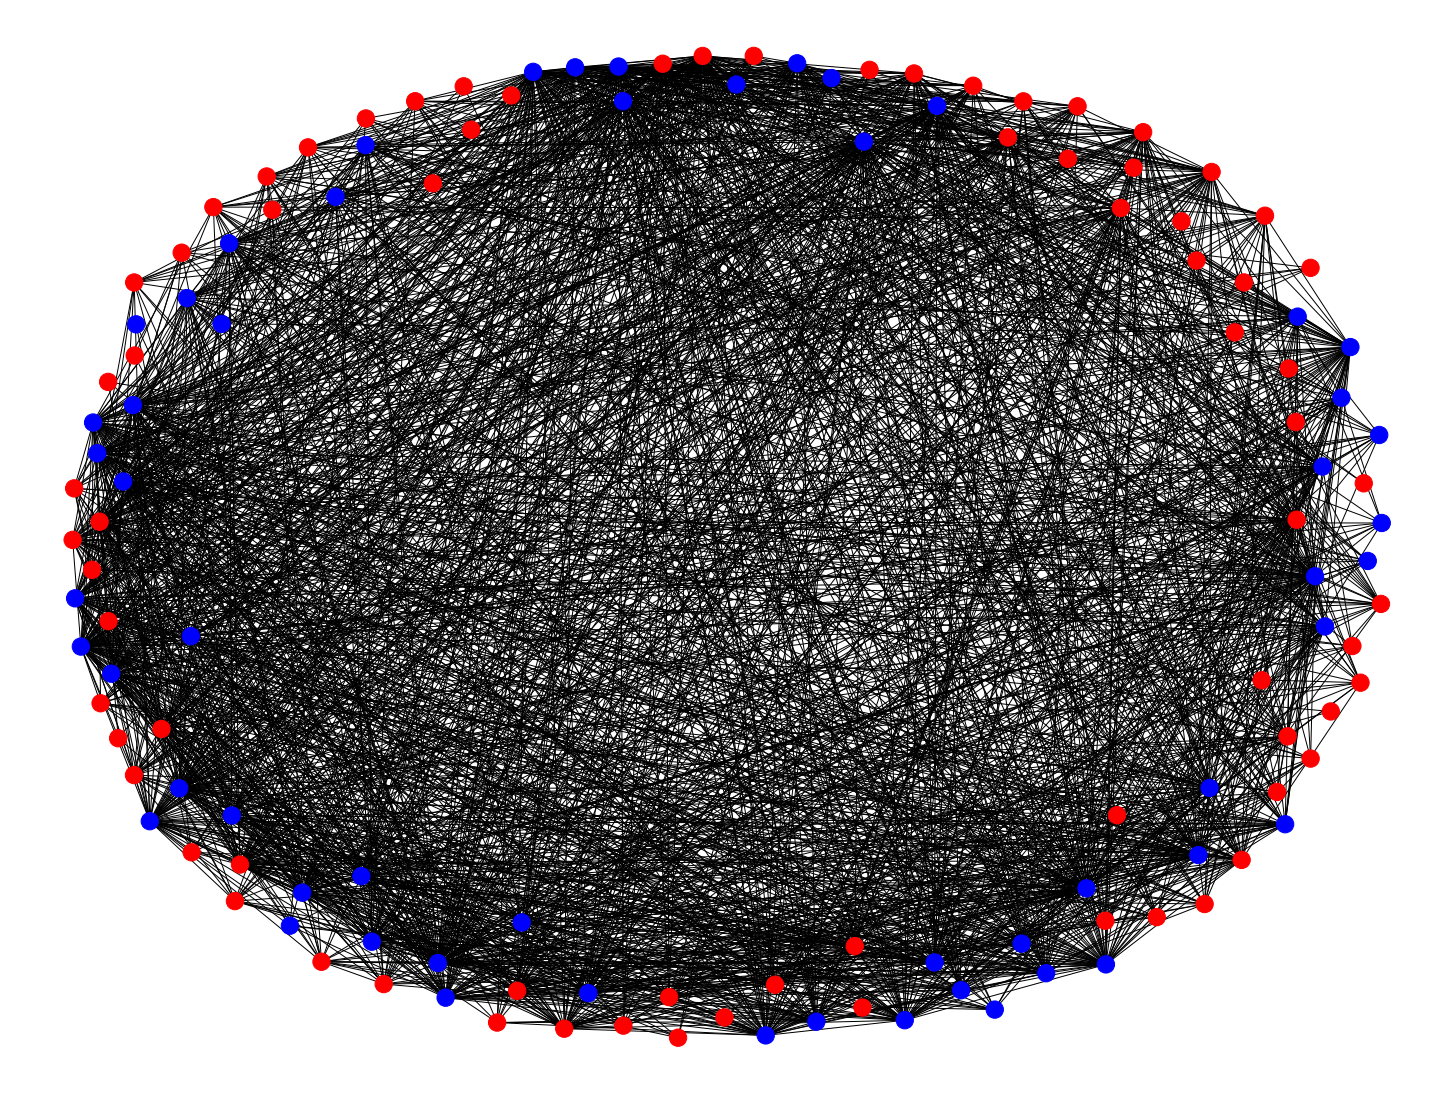

In [74]:
fig = plt.figure(figsize=(20,15))
cmap = cm.get_cmap('bwr', max(label_dic_filtered.values()) + 1)
nx.draw(G=G2, pos=nx.spring_layout(G2, k=1),
                       cmap=cmap, node_color=list(label_dic_filtered.values()))
plt.show()

In [75]:
p1, p2 = community.kernighan_lin_bisection(G2)
bisection_label = {}
real_labels = {}



p1g = G2.subgraph(p1)
p2g = G2.subgraph(p2)
print(nx.info(p1g))
print(nx.info(p2g))

if len(p1g.nodes()) <= len(p2g.nodes()):
    for node in p1:
        bisection_label[node] = 0

    for node in p2:
        bisection_label[node] = 1
else:
    for node in p2:
        bisection_label[node] = 0

    for node in p1:
        bisection_label[node] = 1

Name: 
Type: Graph
Number of nodes: 65
Number of edges: 396
Average degree:  12.1846
Name: 
Type: Graph
Number of nodes: 66
Number of edges: 631
Average degree:  19.1212


In [76]:
np.mean([label_dic_filtered[node] == bisection_label[node] for node in G2.nodes()])

0.4580152671755725

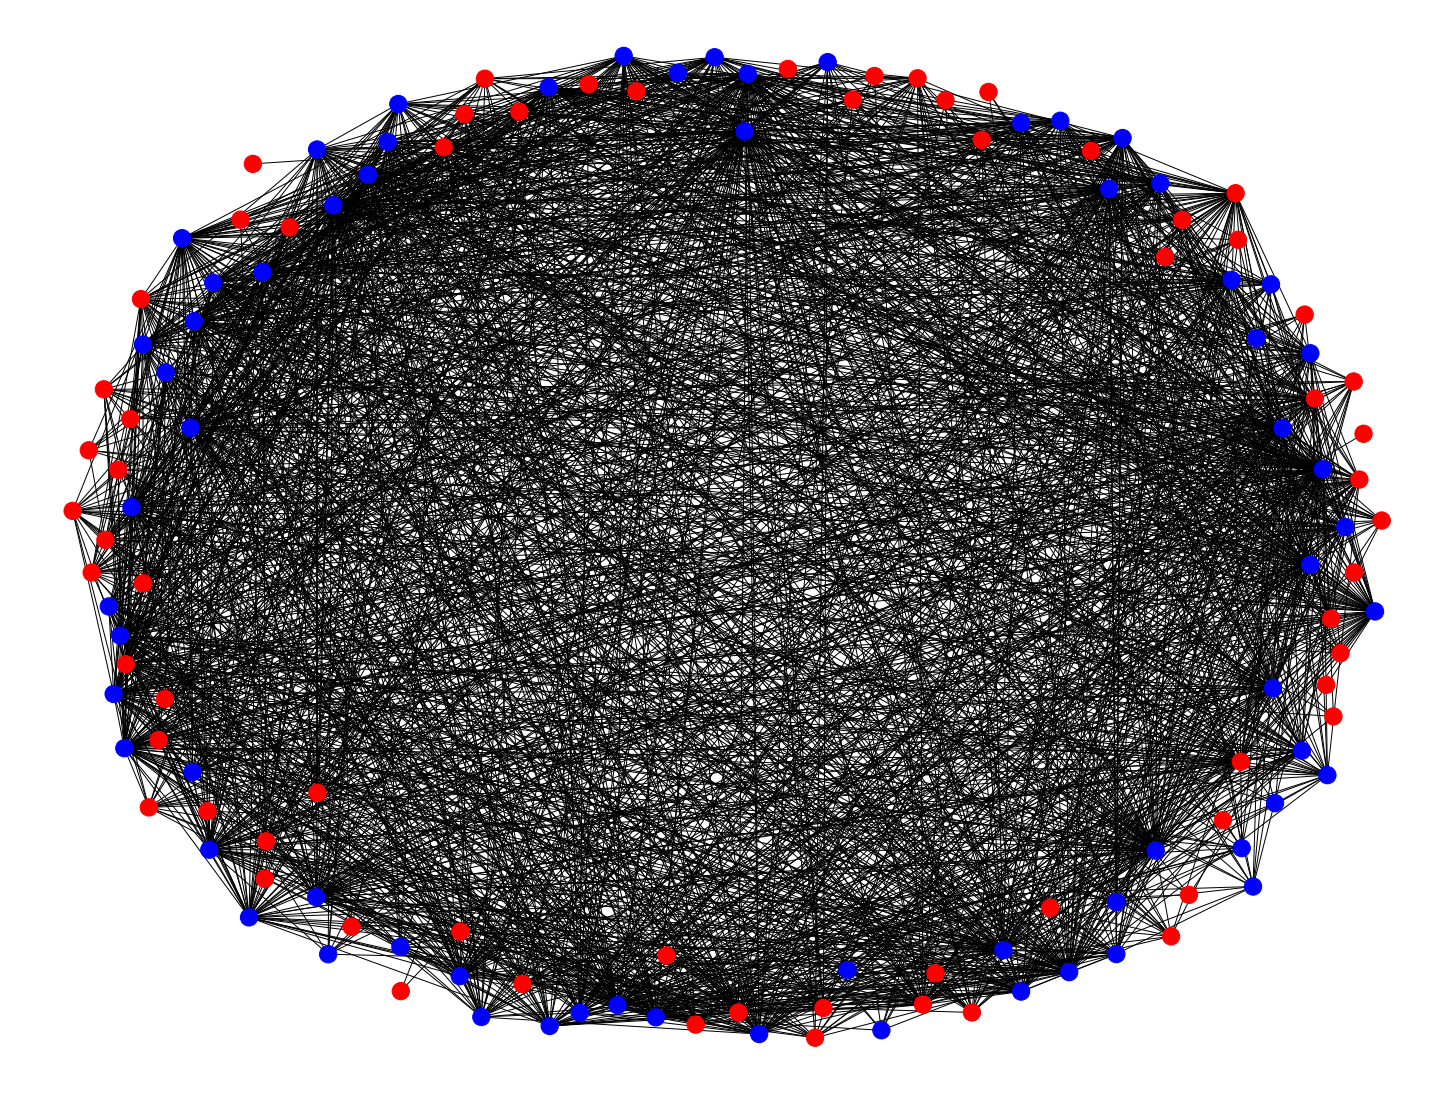

In [77]:
fig = plt.figure(figsize=(20,15))
cmap = cm.get_cmap('bwr', max(bisection_label.values()) + 1)
nx.draw(G=G2, pos=nx.spring_layout(G2, k=1),
                       cmap=cmap, node_color=list(bisection_label.values()))

In [78]:
# community_louvain.best_partition(G2)

## Node embedding